# 投资表现

## 加载模块

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import statsmodels.api as sm

## 读入文件

In [2]:
df_merge = pd.read_csv('../data/stock-accounting.csv')
df_merge['date'] = pd.to_datetime(df_merge['date'])

In [3]:
df_factor = pd.read_csv('../data/F-F_Research_Data_5_Factors_2x3.csv', skiprows=3, nrows=738)
df_factor = df_factor.rename(columns={'Unnamed: 0': 'dint'})
df_factor['dint'] = df_factor['dint'].astype(int)

time_series = df_merge['date'].unique()
time_series = np.sort(time_series)
df_time = pd.DataFrame({'date': time_series})
df_time['dint'] = df_time['date'].dt.year * 100 + df_time['date'].dt.month
df_factor = pd.merge(
    df_time,
    df_factor,
    on='dint',
    how='left'
)

In [4]:
df_mom = pd.read_csv('../data/F-F_Momentum_Factor.CSV', skiprows=13, nrows=1176)
df_mom = df_mom.rename(columns={'Unnamed: 0': 'dint', 'Mom   ': 'UMD'})
df_mom['dint'] = df_mom['dint'].astype(int)

df_factor = pd.merge(
    df_factor,
    df_mom,
    on='dint',
    how='left'
)

## 持有收益率

预处理：每个月的 `RET` 其实是本月相对于上个月的收益，故将 `RET` 上移一位，做到当月的股价与对应收益率相乘

In [5]:
df_ret = df_merge.copy()
df_ret['RET'] = df_merge.groupby('PERMNO')['RET'].shift(-1)
df_ret['RET'] = df_ret['RET'].fillna(0.)
df_ret['adj-prc'] = df_ret['adj-prc'].fillna(0.)

计算收益与时间的关系，适用于两种组合

_Warning: 计算下个月手里的钱：用本月某股票手里的股数 * 本月股价 * (1 + 下月月收益率)，再进行求和_

In [6]:
idx_stg = ['Intro', 'Growth', 'Mature', 'Shakeout', 'Decline']

def share_amount(group):
    g = group.copy()
    amount = g['weight'] * g['stg-value'] * g['market-cap'] / g['market-cap'].sum()
    amount = amount / g['adj-prc']
    amount.fillna(0)
    amount.name = 'amount'
    return pd.concat([g['PERMNO'], amount], axis=1)

def value_date(df_ret, by):
    df_value = pd.DataFrame(columns=['date'] + idx_stg)
    df_value['date'] = time_series
    df_value.loc[0, 'Intro': 'Decline'] = 1.
    
    for i, row in df_value.iterrows():
        d = row['date']
        df_date = df_ret.loc[(df_ret['date'] == d) & df_ret['stg'].isin(idx_stg)].copy()
        df_date = df_date.sort_values('PERMNO')
        if ('industry' in by):
            df_date['weight'] = df_date['industry-weight']
            inds_num = df_date['industry'].unique().size
            if (inds_num < 9):
                print(i, inds_num)
        else:
            df_date['weight'] = 1.
        df_date['stg-value'] = 0.
        
        for stg in idx_stg:
            df_date.loc[df_date['stg'] == stg, 'stg-value'] = df_value.loc[i, stg]
    
        df_amount = df_date.groupby(by)[['PERMNO', 'market-cap', 'adj-prc', 'stg-value', 'weight']].apply(share_amount).reset_index()
        df_amount = df_amount[['PERMNO', 'amount']]
        df_amount = df_amount.sort_values('PERMNO')
        df_date = pd.merge(
            df_date,
            df_amount,
            on='PERMNO',
            how='left'
        )
        df_date['value'] = (1 + df_date['RET']) * df_date['amount'] * df_date['adj-prc']
    
        if i < df_value.shape[0] - 1:
            df_value.loc[i + 1, 'Intro': 'Decline'] = df_date.groupby('stg')['value'].sum()

    return df_value

### 市值加权组合

In [7]:
df_value = value_date(df_ret, 'stg')
df_value

,date,Intro,Growth,Mature,Shakeout,Decline
0,1989-01-31,1.0,1.0,1.0,1.0,1.0
1,1989-02-28,1.000894,0.979447,0.977912,1.00592,0.997966
2,1989-03-31,1.001664,1.00015,0.998453,1.031724,1.02713
3,1989-04-28,1.060683,1.054064,1.049755,1.092866,1.087381
4,1989-05-31,1.093052,1.115688,1.083767,1.130126,1.138011
...,...,...,...,...,...,...
403,2022-08-31,1.429263,22.615072,46.418938,27.895701,8.726271
404,2022-09-30,1.281998,20.426517,42.143736,24.864546,7.593699
405,2022-10-31,1.32125,21.367123,45.580554,28.491734,7.970976
406,2022-11-30,1.324376,21.93996,48.067325,29.898276,8.657153


### EXHIBIT 5 - Panel A

In [8]:
colors = ['#b4b4b5', '#bee1ed', '#4959a7', '#ebb9ba', '#ef3c39']
def value_date_plot(df_value, title, file_name):
    for stg, clr in zip(idx_stg, colors):
        plt.plot(df_value['date'], df_value[stg], label=stg, color=clr)
        last_row = df_value.iloc[-1]
        plt.text(last_row['date'], last_row[stg], '{:.2f}'.format(last_row[stg]))
    plt.title(title)
    plt.xlabel('Month')
    plt.ylabel('Return of $1 Invested')
    plt.ylim(0.1, 100)
    plt.yscale('log')
    plt.gca().set_yticks([0.1, 1, 10, 100])
    plt.gca().set_yticklabels(['$0.1', '$1', '$10', '$100'])
    plt.gca().set_box_aspect(0.5)
    plt.legend(ncols=5, loc=[-0.07, -0.3])
    plt.savefig(file_name)
    plt.show()

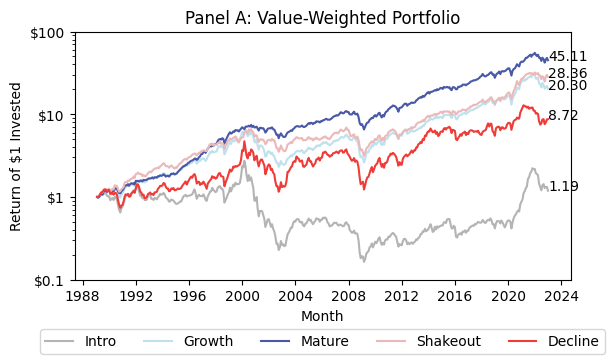

In [9]:
value_date_plot(df_value, title='Panel A: Value-Weighted Portfolio', file_name='../exhibits/Exhibit5-PanelA.png')

### 行业加权组合

首先定义行业

_Warning: 计算行业加权组合权重的方法：用每个周期阶段组合里的所有数据，计算总的各行业市值，除以总的周期市值，得到固定的行业权重_

In [10]:
df_ret['industry'] = ''

industry_name = ''
with open('../data/Siccodes10.txt', 'r') as file:
    for line in file.readlines():
        line_split = line
        line_split = line_split.replace('-', ' ')
        line_split = line_split.replace('\n', '')
        line_split = line_split.split(' ')
        line_split = list(filter(None, line_split))
        if (len(line_split) < 2):
            continue
        if (line_split[0].isdigit() and not line_split[1].isdigit()):
            industry_name = line_split[1]
        elif (line_split[0].isdigit() and line_split[1].isdigit()):
            low = int(line_split[0])
            high = int(line_split[1])
            df_ret.loc[df_ret['SICCD'].isin(range(low, high + 1)), 'industry'] = industry_name
df_ret['industry'] = df_ret['industry'].replace('', 'Other')

df_weight = df_ret.groupby(['stg', 'industry'])['market-cap'].sum().reset_index()
df_market = df_ret.groupby('stg')['market-cap'].sum().reset_index()
df_market = df_market.rename(columns={'market-cap': 'market-sum'})
df_weight = pd.merge(
    df_weight,
    df_market,
    on='stg',
    how='left'
)
df_weight['industry-weight'] = df_weight['market-cap'] / df_weight['market-sum']
df_ret = pd.merge(
    df_ret,
    df_weight[['stg', 'industry', 'industry-weight']],
    on=['stg', 'industry'],
    how='left'
)

In [11]:
df_industry = value_date(df_ret, by=['stg', 'industry'])
df_industry

,date,Intro,Growth,Mature,Shakeout,Decline
0,1989-01-31,1.0,1.0,1.0,1.0,1.0
1,1989-02-28,1.008347,0.981208,0.9739,1.011197,0.998161
2,1989-03-31,1.008637,0.999672,0.977422,1.02214,1.029556
3,1989-04-28,1.051621,1.056366,1.029947,1.077363,1.06038
4,1989-05-31,1.087857,1.116608,1.057034,1.105847,1.09966
...,...,...,...,...,...,...
403,2022-08-31,0.683681,30.972669,56.660856,38.61023,5.595817
404,2022-09-30,0.61135,27.895244,51.579609,34.511289,4.994947
405,2022-10-31,0.62639,29.881253,56.548403,39.657622,5.169534
406,2022-11-30,0.629722,30.770734,59.629551,41.891271,5.432094


### EXHIBIT 5 - Panel B

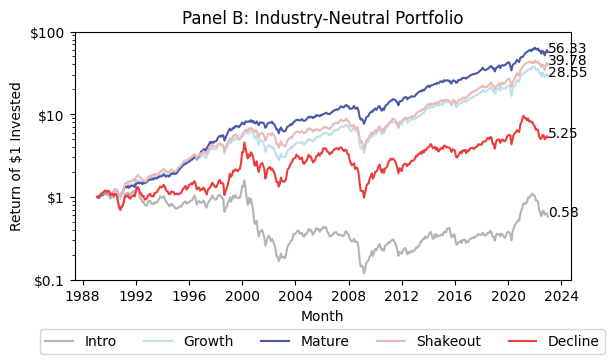

In [12]:
value_date_plot(df_industry, title='Panel B: Industry-Neutral Portfolio', file_name='../exhibits/Exhibit5-PanelB.png')

### EXHIBIT 6

In [13]:
def excess_ret(value):
    v = value.copy()
    log_v = v.astype(float).apply(np.log)
    log_diff = log_v.diff()
    div = log_diff.apply(np.exp)
    return div - 1

df_exc_value = pd.DataFrame(columns=['date'] + idx_stg)
df_exc_value['date'] = time_series
df_exc_value.loc[:, idx_stg] = excess_ret(df_value.loc[:, idx_stg])
df_exc_value.loc[:, idx_stg] = df_exc_value.loc[:, idx_stg].sub(df_factor['RF'] / 100., axis=0)

df_exc_industry = pd.DataFrame(columns=['date'] + idx_stg)
df_exc_industry['date'] = time_series
df_exc_industry.loc[:, idx_stg] = excess_ret(df_industry.loc[:, idx_stg])
df_exc_industry.loc[:, idx_stg] = df_exc_industry.loc[:, idx_stg].sub(df_factor['RF'] / 100., axis=0)

df_sp = pd.DataFrame(columns=idx_stg)
df_sp.loc['erA'] = df_exc_value[idx_stg].mean()
df_sp.loc['sdA'] = df_exc_value[idx_stg].std()
df_sp.loc['erB'] = df_exc_industry[idx_stg].mean()
df_sp.loc['sdB'] = df_exc_industry[idx_stg].std()
df_sp.loc[['erA', 'erB']] = ((1 + df_sp.loc[['erA', 'erB']]) ** 12 - 1) * 100.
df_sp.loc[['sdA', 'sdB']] *= 100 * np.sqrt(12)
df_sp.loc['spA'] = df_sp.loc['erA'] / df_sp.loc['sdA']
df_sp.loc['spB'] = df_sp.loc['erB'] / df_sp.loc['sdB']
df_sp = df_sp.loc[['erA', 'sdA', 'spA', 'erB', 'sdB', 'spB']]
df_sp = df_sp.rename({'erA': 'A: Excess Return, Annualized (%)', 'erB': 'B: Excess Return, Annualized (%)',
                      'sdA': 'A: Standard Deviation, Annualized (%)', 'sdB': 'B: Standard Deviation, Annualized (%)',
                      'spA': 'A: Sharpe Ratio', 'spB': 'B: Sharpe Ratio'})

df_sp.to_csv('../exhibits/Exhibit6.csv')
pd.options.display.float_format = '{:.2f}'.format
df_sp

,Intro,Growth,Mature,Shakeout,Decline
"A: Excess Return, Annualized (%)",2.16,8.40,10.05,9.04,7.96
"A: Standard Deviation, Annualized (%)",28.98,19.06,14.04,16.94,28.03
A: Sharpe Ratio,0.07,0.44,0.72,0.53,0.28
"B: Excess Return, Annualized (%)",-0.09,9.53,10.86,10.27,6.34
"B: Standard Deviation, Annualized (%)",28.56,19.22,14.54,17.65,28.00
B: Sharpe Ratio,-0.00,0.50,0.75,0.58,0.23


## 因子暴露

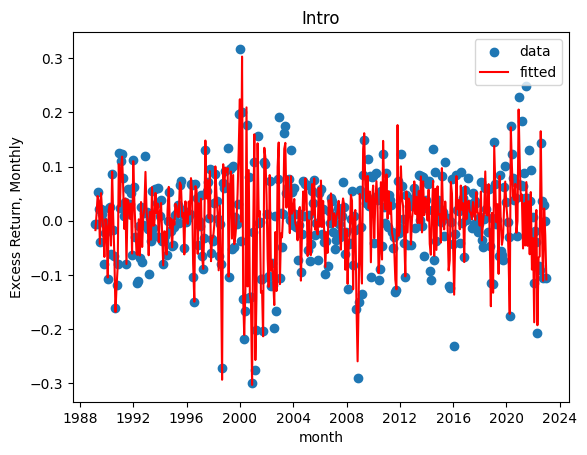

,Intro,Growth,Mature,Shakeout,Decline
const,-0.25,0.05,0.05,-0.09,0.10
const-t,-1.59,0.75,1.48,-0.93,0.59
const-s,,,,,
Mkt-RF,1.20,1.10,0.95,1.05,1.17
Mkt-RF-t,30.34,68.40,103.47,44.34,26.90
Mkt-RF-s,***,***,***,***,***
SMB,0.68,0.12,-0.06,0.14,0.75
SMB-t,11.95,5.08,-4.18,4.13,12.11
SMB-s,***,***,***,***,***
HML,-0.34,-0.14,-0.11,-0.18,-0.35


In [15]:
idx_fac = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'UMD']
x = df_factor.loc[1:, idx_fac].astype(float)
x = sm.add_constant(x)

def significance_p(pvalue):
    if pvalue < 0.01:
        return '***'
    elif pvalue < 0.05:
        return '**'
    elif pvalue < 0.1:
        return '*'

df_params = pd.DataFrame(index=x.columns, columns=idx_stg, dtype=float)
df_tvalues = df_params.copy()
df_significance = df_params.copy().astype(str)
df_stat = pd.DataFrame(index=['R Squared', 'Adjusted R Squared', 'Observations'],
                       columns=idx_stg, dtype = float)

for stg in idx_stg:
    y = df_exc_value.loc[1:, stg].astype(float)
    result = sm.OLS(y, x).fit()
    df_params[stg] = result.params * 100
    df_tvalues[stg] = result.tvalues
    df_significance[stg] = result.pvalues.apply(significance_p)
    df_stat.loc['R Squared', stg] = result.rsquared
    df_stat.loc['Adjusted R Squared', stg] = result.rsquared_adj
    df_stat.loc['Observations', stg] = result.nobs
    
    if stg == 'Intro':
        y_pred = result.predict(x)
        plt.scatter(df_factor.loc[1:, 'date'], y, label='data')
        plt.plot(df_factor.loc[1:, 'date'], y_pred, color='red', label='fitted')
        plt.title(stg)
        plt.xlabel('month')
        plt.ylabel('Excess Return, Monthly')
        plt.legend()
        plt.show()

df_tvalues = df_tvalues.rename({idx: idx + '-t' for idx in x.columns})
df_significance = df_significance.rename({idx: idx + '-s' for idx in x.columns})
df_significance = df_significance.fillna('')
df_exposure = pd.concat([df_params, df_tvalues, df_significance, df_stat])
df_exposure = df_exposure.loc[['const', 'const-t', 'const-s', 'Mkt-RF', 'Mkt-RF-t', 'Mkt-RF-s',
                 'SMB', 'SMB-t', 'SMB-s', 'HML', 'HML-t', 'HML-s',
                 'RMW', 'RMW-t', 'RMW-s', 'CMA', 'CMA-t', 'CMA-s',
                 'UMD', 'UMD-t', 'UMD-s', 'R Squared', 'Adjusted R Squared', 'Observations']]
df_exposure.to_csv('../exhibits/Exhibit7.csv')
df_exposure